In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
import seaborn as sns
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Reviews and Raitings
## Basic analisys and comparison between them¶
## Author: Martin Kenarov
### Abstract

The main purpose of this paper is to understand how ratings and reviews for a certain product or service are connected. I will do basic sentiment analysis with the library TextBlob. I will use the library to calculate polarity and subjectivity for every review and will compare it to the rating. The low rating must meet low polarity and respectively the high rating should also meet high polarity. I will use 2 datasets – Women’s Clothing Reviews and Hotel Reviews.

    -Polarity is a float value within the range [-1.0 to 1.0] where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.
    - Subjectivity is a float value within the range [0.0 to 1.0] where 0.0 is very objective and 1.0 is very subjective. Subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations whereas Objective sentences are factual.
Through polarity and subjectivity can be measured emotions expressed in a review.

Five-grained rating:
- Very positive: 5 
- Positive: 4 
- Neural: 3 
- Negative: 2 
- Very Negative: 1

In [3]:
# load first dataset 
womens_clothing_data = pd.read_csv('./data/womens_clothing_reviews.csv', index_col=0)
womens_clothing_data.sample(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
13630,1078,49,Love this dress,"I am a petite girl, 5'2""/105 lbs- i bought siz...",5,1,1,General,Dresses,Dresses
16698,8,38,Cute suit-didn't work for me,"This suit was high quality, and a cute design....",1,0,0,Initmates,Intimate,Swim
7847,1053,38,NaN,I was so excited to get this! the fabric is be...,3,0,0,General,Bottoms,Pants
19397,995,22,Love it!,"I just got this skirt in the mail, and i'm abs...",5,1,3,General,Bottoms,Skirts
20787,862,56,Soooooo cute,I really like this. it's not too baggy and not...,5,1,0,General Petite,Tops,Knits


### 1. Expolatory Data Analysis and Data Visualization

In [4]:
womens_clothing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


### Helper functions

In [5]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)

def plot_ratings(ratings):
    plt.figure(figsize=(8,4))

    plt.bar(range(len(ratings)), ratings.values, align='center')
    plt.xticks(range(len(ratings)), ratings.index)
    plt.title("Distribution of ratings")
    plt.xlabel('Review Ratings')
    plt.ylabel('Count')
    plt.show()

def calculate_sentiment(review):
    return TextBlob(review).sentiment

def get_most_common_words(reviews, stopwords):
    wd_counts = Counter()
    for i, row in womens_clothing_reviews.iterrows():
        wd_counts.update(row['clean_text'].split())
    
    for sw in stopwords.words('english'):
        del wd_counts[sw]
    return wd_counts.most_common(20)

def plot_words_distribution(words, title):
    ax=words.plot(kind='hist', bins=50, fontsize=14, figsize=(12,10))
    ax.set_title(title, fontsize=18)
    ax.set_ylabel('Frequency', fontsize=18)
    ax.set_xlabel('Number of Words', fontsize=18);
    plt.show()

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    
    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

#### Get only the data we will need to our analysis

In [6]:
womens_clothing_reviews = womens_clothing_data[["Review Text", "Rating"]]
womens_clothing_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


#### Renamed columns to be more well to acssess to them.

In [7]:
womens_clothing_reviews.columns = ["review", "rating"]
womens_clothing_reviews.head()

,review,rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


In [8]:
womens_clothing_reviews.dtypes

review    object
rating     int64
dtype: object

#### Check that if in rows has any cells without values

In [9]:
womens_clothing_reviews.isna().any()

review     True
rating    False
dtype: bool

In [10]:
# Get the percent of rows with cells without values

In [11]:
womens_clothing_reviews.isna().sum() / len(womens_clothing_reviews) * 100

review    3.597888
rating    0.000000
dtype: float64

In [12]:
womens_clothing_reviews[womens_clothing_reviews.review.isnull()]

,review,rating
92,NaN,5
93,NaN,5
98,NaN,5
135,NaN,4
142,NaN,5
165,NaN,3
168,NaN,5
192,NaN,5
201,NaN,5
248,NaN,5


We remove observations that are unrated, as we are going to explore the relationship between reviews and ratings.

In [13]:
womens_clothing_reviews = womens_clothing_reviews[womens_clothing_reviews.review.notnull()]

A litle preprocessing.

In [14]:
womens_clothing_reviews['clean_text'] = womens_clothing_reviews['review'].map(lambda x: clean_text(x))

In [15]:
womens_clothing_reviews['clean_text'].head()

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happen find store i'm g...
2    high hope dress really wanted work initially o...
3    love love love jumpsuit fun flirty fabulous ev...
4    shirt flatter due adjustable front tie perfect...
Name: clean_text, dtype: object

#### Counting words for every review and show the for dataset.

In [16]:
womens_clothing_reviews['num_words'] = womens_clothing_reviews['clean_text'].apply(lambda x: len(x.split()))
womens_clothing_reviews['num_words'].mean()

28.281833841261427

In [17]:
print("Max words for review: {}".format(womens_clothing_reviews['num_words'].max()))
print("Min words for review: {}".format(womens_clothing_reviews['num_words'].min()))

Max words for review: 58
Min words for review: 2


In [18]:
len(womens_clothing_reviews['num_words'] == 1)

22641

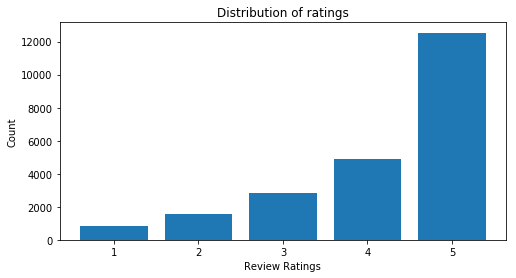

In [19]:
ratings = womens_clothing_reviews["rating"].value_counts()
ratings = ratings.sort_index()

plot_ratings(ratings)

#### Here we show the number of words in a review and frequency of encounter

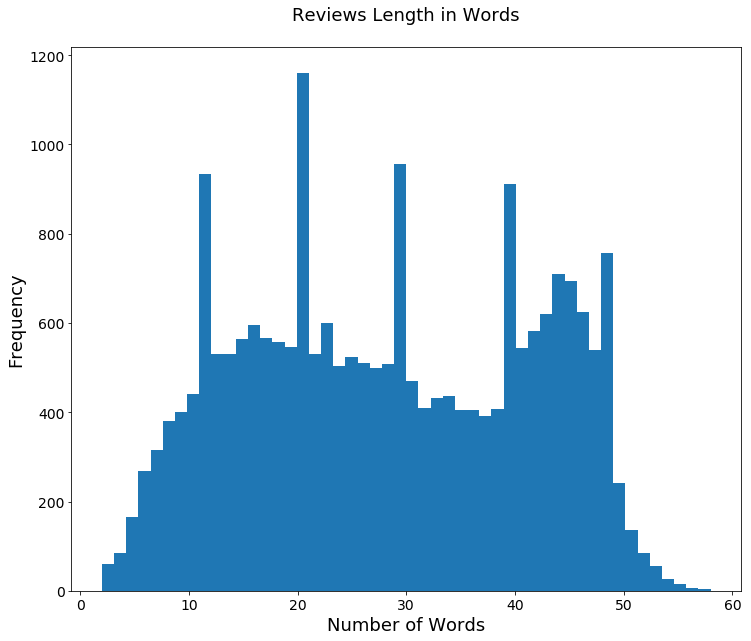

In [20]:
plot_words_distribution(womens_clothing_reviews['num_words'], 'Reviews Length in Words\n')

In [21]:
womens_clothing_reviews['uniq_words'] = womens_clothing_reviews['clean_text'].str.split().apply(lambda x: len(set(x)))
womens_clothing_reviews['uniq_words'].head()

0     5
1    25
2    40
3    12
4    15
Name: uniq_words, dtype: int64

In [22]:
print(womens_clothing_reviews['uniq_words'].mean())
print(womens_clothing_reviews['uniq_words'].min())
print(womens_clothing_reviews['uniq_words'].max())

25.58336645907866
2
53


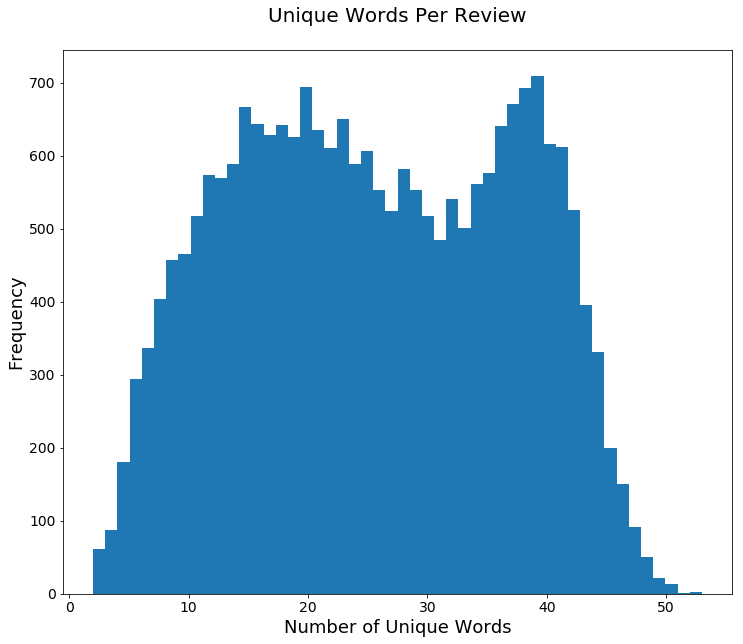

In [23]:
ax=womens_clothing_reviews['uniq_words'].plot(kind='hist', bins=50, fontsize=14, figsize=(12,10))
ax.set_title('Unique Words Per Review\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Number of Unique Words', fontsize=18);

In [24]:
most_common_words = get_most_common_words(womens_clothing_reviews, stopwords)
print("Print most common words in reviews: \n{}".format(most_common_words))

Print most common words in reviews: 
[('dress', 11932), ('fit', 10931), ('size', 10327), ('love', 10144), ('look', 9154), ('wear', 8749), ('top', 8180), ('like', 7456), ('color', 7053), ('great', 6078), ("i'm", 5843), ('small', 5229), ('would', 5010), ('fabric', 4818), ('get', 4814), ('order', 4507), ('make', 4154), ('go', 4118), ('really', 3920), ('well', 3884)]


#### We divide the reviews into two groups - positive and negative. As a treshold we assume that those with a rating of less than 3 are negative, while those with a rating of 3 or more are negative.

In [25]:
womens_clothing_reviews['is_bad_review'] = womens_clothing_reviews['rating'].apply(lambda x: 1 if x < 3 else 0)

In [26]:
len(womens_clothing_reviews[womens_clothing_reviews["is_bad_review"] == 0]) / len(womens_clothing_reviews)

0.8953226447595071

In [27]:
sentiment = womens_clothing_reviews['review'].apply(calculate_sentiment)
polarity = sentiment.apply(lambda x: x[0]).values
subjectivity = sentiment.apply(lambda x: x[1]).values
womens_clothing_reviews['polarity'] = polarity
womens_clothing_reviews['subjectivity'] = subjectivity

In [28]:
womens_clothing_reviews["num_chars"] = womens_clothing_reviews["clean_text"].apply(lambda x: len(x))

In [29]:
# show is_bad_distrubution
womens_clothing_reviews['is_bad_review'].value_counts(normalize = True)

0    0.895323
1    0.104677
Name: is_bad_review, dtype: float64

#### Word cloud is a common way of visualizing a text corpus to understand the frequently used words.

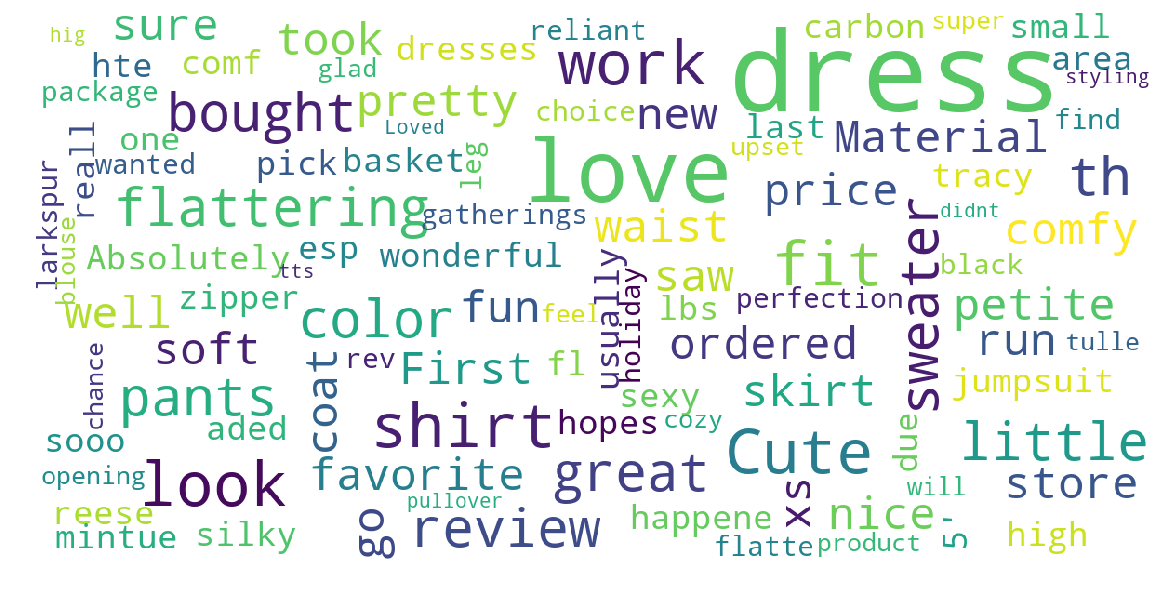

In [30]:
show_wordcloud(womens_clothing_reviews["review"])

In [31]:
negative_reviews = womens_clothing_reviews[womens_clothing_reviews["is_bad_review"] == 1].groupby("polarity").size().nlargest(10)
negative_reviews

polarity
 0.000000    28
 0.500000    17
 0.150000    14
 0.250000    14
 0.175000    11
 0.100000    10
 0.166667     9
 0.200000     9
-0.100000     8
 0.350000     8
dtype: int64

In [32]:
positive_reviews = womens_clothing_reviews[womens_clothing_reviews["is_bad_review"] == 0].groupby("polarity").size().nlargest(10)
positive_reviews

polarity
0.500    135
0.250     99
0.300     87
0.450     67
0.000     64
0.375     64
0.350     60
0.400     59
0.600     53
0.200     50
dtype: int64

#### Plot word count distribution for both positive and negative sentiments

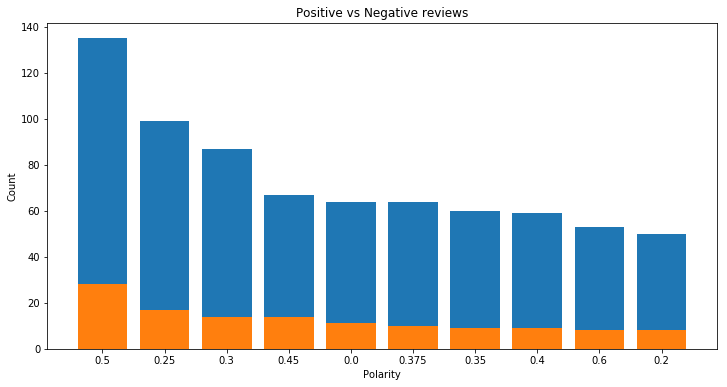

In [33]:
plt.figure(figsize=(12,6))
plt.bar(range(len(positive_reviews)), positive_reviews.values, align='center')
plt.bar(range(len(negative_reviews)), negative_reviews.values, align='center')
plt.xticks(range(len(positive_reviews)), positive_reviews.index)
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.title("Positive vs Negative reviews")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


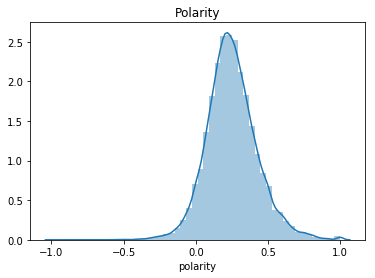

In [34]:
sns.distplot(womens_clothing_reviews["polarity"])
plt.title("Polarity")
plt.show()

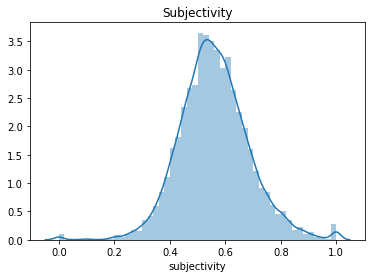

In [35]:
sns.distplot(womens_clothing_reviews["subjectivity"])
plt.title("Subjectivity")
plt.show()

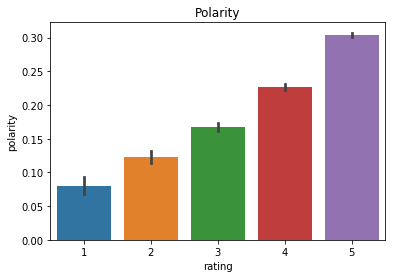

In [36]:
sns.barplot(x='rating', y='polarity', data=womens_clothing_reviews)
plt.title("Polarity")
plt.show()

In [37]:
len(womens_clothing_reviews[(womens_clothing_reviews["polarity"] > 0.2) & (womens_clothing_reviews["rating"] < 2)])

196

In [38]:
len(womens_clothing_reviews[(womens_clothing_reviews["polarity"] < 0) & (womens_clothing_reviews["rating"] >= 3)])

779

In [39]:
outliers = womens_clothing_reviews[(womens_clothing_reviews["polarity"] < 0) & (womens_clothing_reviews["rating"] >= 3)]

In [40]:
womens_clothing_reviews["polarity"].corr(womens_clothing_reviews["rating"])

0.3863030372204919

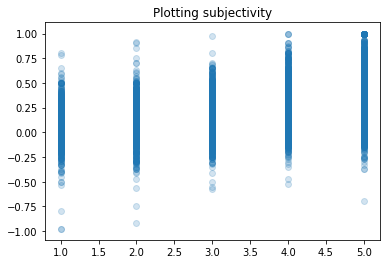

In [41]:
plt.scatter(womens_clothing_reviews["rating"], womens_clothing_reviews["polarity"], alpha = 0.2)
plt.title("Plotting subjectivity")
plt.show()

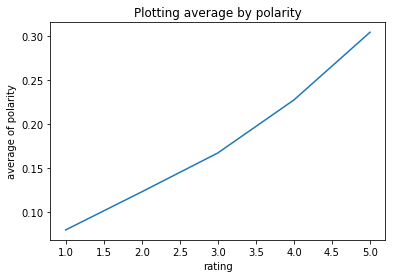

In [55]:
reviews_average_by_polarity = womens_clothing_reviews.groupby("rating")["polarity"].mean()

plt.plot(reviews_average_by_polarity.index, reviews_average_by_polarity.values, alpha = 1)
plt.title("Plotting average by polarity")
plt.xlabel("rating")
plt.ylabel("average of polarity")
plt.show()

In [ ]:
plt.scatter(womens_clothing_reviews["rating"], womens_clothing_reviews["subjectivity"], alpha = 0.2)
plt.title("Plotting subjectivity")
plt.show()

In [ ]:
plt.scatter(womens_clothing_reviews["subjectivity"], womens_clothing_reviews["polarity"], alpha = 0.2)
plt.title("Polarity and Subjectivity")
plt.xlabel("Subjectivity")
plt.ylabel("Polarity")
plt.show()

#### Load second dataset to test our hypotesis on its.
За да разберем по добре дали има връзка, или няма ще работим и с втори dataset в различна област. Тук пак ще са ревюта и рейтинги, но ще бъдат за хотели.

In [ ]:
hotel_reviews = pd.read_csv('./data/hotel_ratings.csv', encoding = "ISO-8859-1", index_col = "S.No.")
hotel_reviews.sample(5)

In [ ]:
hotel_reviews.info()

In [ ]:
ratings = hotel_reviews["Rating"].value_counts()
ratings = ratings.sort_index()

plot_ratings(ratings)

Check if has any rows wothout values

In [ ]:
hotel_reviews.isna().any()

Here is no nesesery to remove rows, because there are no reviews without text.

In [ ]:
hotel_reviews['clean_text'] = hotel_reviews['Review'].map(lambda x: clean_text(x))

In [ ]:
hotel_reviews['num_words'] = hotel_reviews['clean_text'].apply(lambda x: len(x.split()))
hotel_reviews['num_words'].mean()

In [ ]:
print(hotel_reviews['num_words'].max())
print(hotel_reviews['num_words'].min())

In [ ]:
len(hotel_reviews['num_words'] == 1)

In [ ]:
plot_words_distribution(hotel_reviews['num_words'], 'Reviews Length in Words\n')

In [ ]:
hotel_reviews['uniq_words'] = hotel_reviews['clean_text'].str.split().apply(lambda x: len(set(x)))
hotel_reviews['uniq_words'].head()

In [ ]:
ax=hotel_reviews['uniq_words'].plot(kind='hist', bins=50, fontsize=14, figsize=(12,10))
ax.set_title('Unique Words Per Review\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Number of Unique Words', fontsize=18);

In [ ]:
most_common_words = get_most_common_words(hotel_reviews, stopwords)

print("Print most common words in reviews: \n{}".format(most_common_words))

In [ ]:
hotel_reviews['is_bad_review'] = hotel_reviews['Rating'].apply(lambda x: 1 if x < 3 else 0)

In [ ]:
len(hotel_reviews[hotel_reviews["is_bad_review"] == 0]) / len(hotel_reviews)

И тук се забелязва същата тенденция, рейтинга да е позитивен. 

In [ ]:
hotel_reviews["num_chars"] = hotel_reviews["clean_text"].apply(lambda x: len(x))

In [ ]:
sentiment = hotel_reviews['Review'].apply(calculate_sentiment)
hotel_reviews['polarity'] = sentiment.apply(lambda x: x[0]).values
hotel_reviews['subjectivity'] = sentiment.apply(lambda x: x[1]).values

Две неща забелязах, хората обичат да дават високи оценки и textblob ne raboti dobre za sentiment analysis

In [ ]:
hotel_reviews['is_bad_review'].value_counts(normalize = True)

In [ ]:
show_wordcloud(hotel_reviews["Review"])

In [ ]:
negative_reviews = hotel_reviews[hotel_reviews["is_bad_review"] == 1].groupby("polarity").size().nlargest(10)
negative_reviews

In [ ]:
positive_reviews = hotel_reviews[hotel_reviews["is_bad_review"] == 0].groupby("polarity").size().nlargest(10)
positive_reviews

In [ ]:
# plot word count distribution for both positive and negative sentiments
plt.figure(figsize=(12,6))
plt.bar(range(len(positive_reviews)), positive_reviews.values, align='center')
plt.bar(range(len(negative_reviews)), negative_reviews.values, align='center')
plt.xticks(range(len(positive_reviews)), positive_reviews.index)
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.title("Positive vs Negative reviews")
plt.show()

In [ ]:
sns.distplot(hotel_reviews["polarity"])
plt.show()

In [ ]:
sns.distplot(hotel_reviews["subjectivity"])
plt.title("Plotting subjectivity")
plt.show()

In [ ]:
sns.barplot(x='Rating', y='polarity', data=hotel_reviews)
plt.title("Ratings with polarity")
plt.show()

In [ ]:
# As we can see lower level rating has lower polarity.
plt.scatter(hotel_reviews["Rating"], hotel_reviews["polarity"], alpha = 0.2)
plt.title("Distribution of polarity for ratings")
plt.show()

In [ ]:
plt.scatter(hotel_reviews["Rating"], hotel_reviews["subjectivity"], alpha = 0.2)
plt.title("Distribution of subjectivity for ratings")
plt.show()

#### Here we see for the most part, most of the reviews are subjective.

In [ ]:
# Compute the correlation matrix
ax = sns.heatmap(hotel_reviews.corr(),annot=True,linewidth = 0.5, cmap='coolwarm')
ax.set_title('Correlation matrix')
plt.show()

### References:
- https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e
- https://towardsdatascience.com/having-fun-with-textblob-7e9eed783d3f
- https://www.dataquest.io/blog/tutorial-text-analysis-python-test-hypothesis/
- https://planspace.org/20150607-textblob_sentiment/
- https://pythonprogramming.net/sentiment-analysis-python-textblob-vader/
https://www.absentdata.com/python-graphs/create-a-heat-map-with-seaborn/